# A notebook for computing evaporation rates from PIPS data and radar retrievals

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as feature
# from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# date = '052516' # '053122' # '030622' # '061416'

PIPS_base_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/"
deployment_name = "IOP2_033022"
PIPS_dir = os.path.join(PIPS_base_dir, deployment_name, 'netcdf')

PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
intervalstr = f'{parsivel_interval:d}S'
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]

conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]

parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [3]:
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_read_dict[PIPS_name]
    print(parsivel_ds['time'][0], parsivel_ds['time'][-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:50:13.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:50:13
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:25:23.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:25:23
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:42:43.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:42:43
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:30:33.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:30:33
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:59:33.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:59:33
    flagged_times  int64 

In [4]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
start_time = '2023-03-16T17:45'
end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [5]:
parsivel_ds_dict['PIPS1A']

<xarray.Dataset> Size: 16MB
Dimensions:                    (time: 572, parameter: 3, fields_KGWX: 27,
                                fallspeed_bin: 32, diameter_bin: 32)
Coordinates:
  * time                       (time) datetime64[ns] 5kB 2022-03-30T23:50:13 ...
  * parameter                  (parameter) <U5 60B 'N0' 'lamda' 'alpha'
  * fields_KGWX                (fields_KGWX) <U13 1kB 'REF' ... 'Dm43_Z01_4dB'
    fallspeed                  (fallspeed_bin) float64 256B 0.05 0.15 ... 20.8
    diameter                   (diameter_bin) float64 256B 0.0625 ... 24.5
    min_diameter               (diameter_bin) float64 256B 0.0 0.125 ... 23.0
    max_diameter               (diameter_bin) float64 256B 0.125 0.25 ... 26.0
    min_fallspeeds             (fallspeed_bin) float64 256B 0.0 0.1 ... 19.2
    max_fallspeeds             (fallspeed_bin) float64 256B 0.1 0.2 ... 22.4
    flagged_times              (time) int64 5kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Dimensions without coordinates: fallspeed_bin, diameter_bin
Data variables: (12/140)
    precipintensity            (time) float64 5kB 6.557 6.884 ... 5.461 5.681
    precipaccum                (time) float64 5kB 0.09 0.11 0.13 ... 34.6 34.62
    parsivel_dBZ               (time) float64 5kB 37.81 37.95 ... 38.01 36.59
    sample_interval            (time) timedelta64[ns] 5kB 00:00:10 ... 00:00:10
    signal_amplitude           (time) float64 5kB 2.004e+04 ... 1.243e+04
    pcount                     (time) int64 5kB 58 57 48 54 55 ... 45 49 47 46
    ...                         ...
    W_retr_Z01_4dB_roqc        (time) float64 5kB 0.4436 0.3844 ... 0.3922
    sigma_retr_Z01_4dB_roqc    (time) float64 5kB 0.6579 0.7191 ... 0.7838 0.605
    Dm43_retr_Z01_4dB_roqc     (time) float64 5kB 1.678 1.759 ... 1.846 1.608
    ND_retr_Z01_4dB_roqc       (time, diameter_bin) float64 146kB 0.0 ... nan
    KGWX_beam_height_at_PIPS   (time) float64 5kB 282.1 279.3 ... 287.6 286.0
    KGWX_at_PIPS               (time, fields_KGWX) float64 124kB 33.88 ... 1.443
Attributes:
    nominal sample interval:  10 seconds
    probe_name:               PIPS1A
    parsivel_angle:           -45.0
    deployment_name:          IOP2_033022
    location:                 (33.758010564407854, -88.44616666666666, 70.743...
    starting_time:            20220330235013
    ending_time:              20220331012523
    DSD_interval:             10.0
    retrieval_wavelength:     10.7
    CG_coeff_Z01:             [-1.957  1.213 -0.016]
    CG_coeff_Z01_4dB:         [-1.957  1.213 -0.016]

In [6]:
PIPS_to_plot = 'PIPS1A'
parsivel_ds = parsivel_ds_dict[PIPS_to_plot]

In [7]:
N0_TMM234 = parsivel_ds['DSD_TMM234_roqc'].sel(parameter='N0')
lamda_TMM234 = parsivel_ds['DSD_TMM234_roqc'].sel(parameter='lamda')
alpha_TMM234 = parsivel_ds['DSD_TMM234_roqc'].sel(parameter='alpha')

N0_MM234 = parsivel_ds['DSD_MM234_roqc'].sel(parameter='N0')
lamda_MM234 = parsivel_ds['DSD_MM234_roqc'].sel(parameter='lamda')
alpha_MM234 = parsivel_ds['DSD_MM234_roqc'].sel(parameter='alpha')

N0_retr = parsivel_ds['N0_retr_Z01_4dB_roqc']
lamda_retr = parsivel_ds['lamda_retr_Z01_4dB_roqc']
alpha_retr = parsivel_ds['mu_retr_Z01_4dB_roqc']

N0_retr = N0_retr * 1000.**(1. + alpha_retr)
lamda_retr = lamda_retr * 1000.

rho = parsivel_ds['rho']
T = parsivel_ds['fasttemp'] + 273.15
RH = parsivel_ds['RH_derived']
p = parsivel_ds['pressure'] * 100.


In [8]:
QREVP, EVP_cool_rate = dsd.calc_evap(rho, T, p, RH, N0_TMM234, lamda_TMM234, alpha_TMM234)
QREVP2, EVP_cool_rate2 = dsd.calc_evap(rho, T, p, RH, N0_MM234, lamda_MM234, alpha_MM234)
QREVP3, EVP_cool_rate3 = dsd.calc_evap(rho, T, p, RH, N0_retr, lamda_retr, alpha_retr)

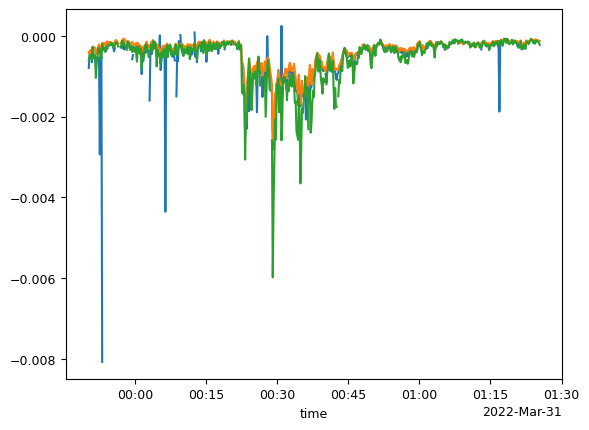

In [9]:
EVP_cool_rate.plot()
EVP_cool_rate2.plot()
EVP_cool_rate3.plot()